In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


## 4. ROI 추출

In [3]:
data = pd.read_csv('골밀도 데이터/train_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1673,8225553,2004-09-30,F,1,11.654795,144.7,33.0,15.8,2016-05-24,2016-05-24,12.00,12.25,NaN,98.jpg,12.125
1,228,5889504,2006-09-15,M,1,8.389041,123.3,25.1,16.6,2014-08-04,2015-02-02,7.00,7.25,NaN,1162.jpg,7.125
2,311,5931393,2000-02-02,M,1,11.161644,138.0,37.0,19.5,2011-03-30,2011-03-30,9.75,11.25,NaN,636.jpg,10.500
3,2053,8807714,2014-08-20,M,1,4.967123,102.5,15.2,14.5,2019-08-07,2019-08-07,4.25,4.00,NaN,990.jpg,4.125
4,32,3726179,2000-05-24,M,1,10.860274,135.5,32.6,17.8,2011-04-01,2011-04-01,9.50,9.75,NaN,618.jpg,9.625


### ROI 추출 위한 함수 정의

ROI 좌표로 iou를 구하는 함수

In [6]:
def get_iou(roi_points,iou_points):
    iou_cor,iou_four,iou_mid = 0,0,0
    
    intersection_cor_x = min(roi_points[0][1][0],iou_points[0][1][0])- max(roi_points[0][0][0],iou_points[0][0][0])
    intersection_cor_y = min(roi_points[0][1][1],iou_points[0][1][1])- max(roi_points[0][0][1],iou_points[0][0][1])
    
    cor_area = (roi_points[0][1][0] - roi_points[0][0][0]) * (roi_points[0][1][1] - roi_points[0][0][1]) + (iou_points[0][1][0] - iou_points[0][0][0]) * (iou_points[0][1][1] - iou_points[0][0][1])
    intersection_cor_area = intersection_cor_x * intersection_cor_y
    
    intersection_four_x = min(roi_points[1][1][0],iou_points[1][1][0])- max(roi_points[1][0][0],iou_points[1][0][0])
    intersection_four_y = min(roi_points[1][1][1],iou_points[1][1][1])- max(roi_points[1][0][1],iou_points[1][0][1])
    
    four_area = (roi_points[1][1][0] - roi_points[1][0][0]) * (roi_points[1][1][1] - roi_points[1][0][1]) + (iou_points[1][1][0] - iou_points[1][0][0]) * (iou_points[1][1][1] - iou_points[1][0][1])
    intersection_four_area = intersection_four_x*intersection_four_y
    
    intersection_mid_x = min(roi_points[2][1][0],iou_points[2][1][0])- max(roi_points[2][0][0],iou_points[2][0][0])
    intersection_mid_y = min(roi_points[2][1][1],iou_points[2][1][1])- max(roi_points[2][0][1],iou_points[2][0][1])
    
    mid_area = (roi_points[2][1][0] - roi_points[2][0][0]) * (roi_points[2][1][1] - roi_points[2][0][1]) + (iou_points[2][1][0] - iou_points[2][0][0]) * (iou_points[2][1][1] - iou_points[2][0][1])
    intersection_mid_area = intersection_mid_x*intersection_mid_y
    
    if intersection_cor_area > 0 and intersection_four_area >0 and intersection_mid_area>0:
        iou_cor = intersection_cor_area / (cor_area - intersection_cor_area)
        iou_four = intersection_four_area / (four_area-intersection_four_area)
        iou_mid = intersection_mid_area / (mid_area - intersection_mid_area)
    
    return iou_cor,iou_four,iou_mid

### 샘플이미지 ROI 추출
+ 샘플 이미지 로드 및 이진화

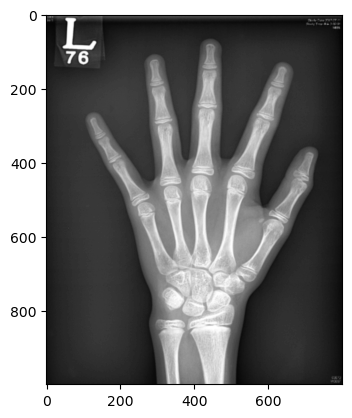

In [4]:
img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img0, 'gray')

In [5]:
# 이미지 thresholding
r_img = np.copy(img0)
height, width = img0.shape
img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

# 이미지 contouring
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_cnt = max(contours, key = cv2.contourArea)
mask = np.zeros(img.shape, dtype= np.uint8)
cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

오목한 좌표와 볼록한 좌표 구하기

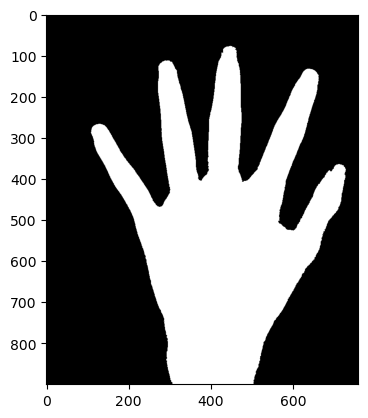

In [6]:
plt.imshow(mask, 'gray')

In [7]:
#좌표 저장공간 설정(첫번째 공간에는 무게중심점, 두번째 공간에는 start점, 세번째에는 far점) 
dots = [[],[],[]]

# 이진화 이미지에서 1차 모멘트 구하기
M = cv2.moments(max_cnt) 
center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
dots[0].append(center)

# 볼록한 점 구하기
hull = cv2.convexHull(max_cnt, returnPoints= False)
hull1 = cv2.convexHull(max_cnt)
hull1.shape

(28, 1, 2)

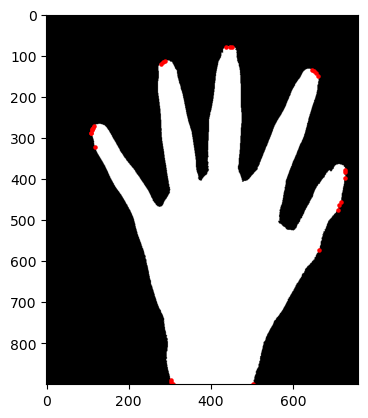

In [8]:
plt.imshow(mask, 'gray')
for grid in hull1:
    x, y = grid[0]
    plt.scatter([x], [y], c = 'red', marker = 'o', s = 5)

plt.show()

In [14]:
# 오목한 지점 구하기
defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환
defects[0,0]

array([1885,    0, 1886,  186], dtype=int32)

In [19]:
max_cnt[1885], max_cnt[0], max_cnt[1886]

(array([[451,  78]], dtype=int32),
 array([[447,  77]], dtype=int32),
 array([[448,  78]], dtype=int32))

In [30]:
# 거리를 저장할 수 있는 공간 생성
di = []

for index in range(defects.shape[0]):
    # 시작점, 끝점, far 점, 거리 할당
    sp, ep, fp, distance = defects[index, 0]
    
    far = tuple(max_cnt[fp][0])
    start = tuple(max_cnt[sp][0])
    end = tuple(max_cnt[ep][0])
    
    # 거리 저장
    di.append(distance)
    dots[1].append(start)
    dots[2].append(far)

# start, far로 분리
start_pt = np.array(dots[1])
far_pt = np.array(dots[2])

far_xrange = []
far_yrange = []
far_miny = 1000
far_maxy = 0
start_miny = 1000

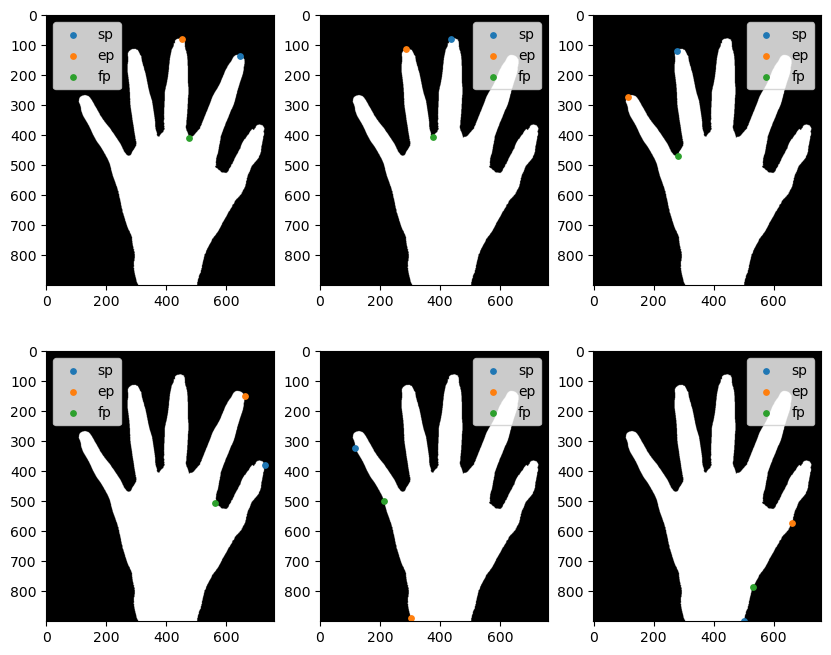

In [31]:
# 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting
di = np.array(di)
s_di = np.sort(di)[::-1]

fig, ax = plt.subplots(2,3, figsize = (10, 8))
for i, dis in enumerate(list(s_di[:6])):
    index = np.where(di == dis)[0][0]
    sp = defects[index, 0][0]
    ep = defects[index, 0][1]
    fp = defects[index, 0][2]
    
    for point in [sp, ep, fp]:
        ax[i//3, i%3].imshow(mask, 'gray')
        ax[i//3, i%3].scatter(max_cnt[point][0][0], max_cnt[point][0][1], s = 15)
        ax[i//3, i%3].legend(['sp', 'ep', 'fp'])
        
plt.show()

In [32]:
far_pt[0]

array([448,  78], dtype=int32)

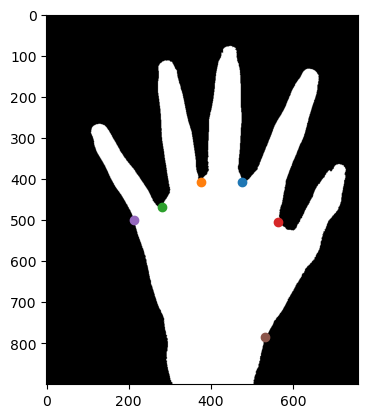

In [33]:
# 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
di = np.array(di)
s_di = np.sort(di)[::-1]

# 내림차순된 거리들을 6개만 뽑아내기 위해 slice
for i in list(s_di[:6]):
    index = np.where(di == i)[0]
    
    # 6개의 좌표들 중에서 가장 최저의 y 값을 찾는다.
    far_miny = min(far_miny, far_pt[index[0]][1])
    
    # 6개의 좌표들 중에서 가장 최고의 y 값을 찾는다.
    far_maxy = max(far_maxy, far_pt[index[0]][1])
    
    # 가장 오목한 지점 6개의 좌표를 출력
    # temp = cv2.circle(img, np.array(far_pt[index[0]]), 2, [255, 255, 255], -1)
    plt.imshow(mask, 'gray')
    plt.scatter(far_pt[index[0]][0], far_pt[index[0]][1])

    # 좌표들이 x, y로 나눠져 있어서 쉽게 비교하기 위해 x, y끼리 나누자.
    far_xrange.append(far_pt[index[0]][0])
    far_yrange.append(far_pt[index[0]][1])
    
# far_xrange 를 오름차순으로 정렬
sorted_far_xrange = np.sort(far_xrange)
sorted_far_yrange = np.sort(far_yrange)

In [34]:
far_xrange, far_yrange

([476, 376, 280, 563, 214, 533], [408, 406, 468, 505, 499, 785])

### 손목뼈 좌표 추출

손목 관절 roi 좌표 


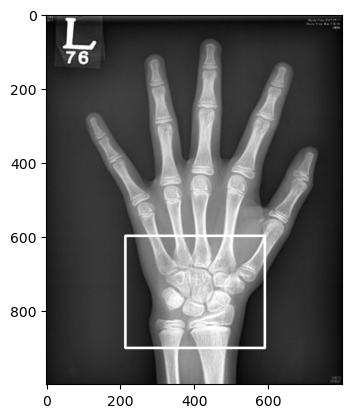

In [35]:
#손목뼈 ROI
carpus_start_point = ((int)(np.sort(far_xrange)[0]),(int)(center[1]*1.15))
carpus_end_point = (int(np.sort(far_xrange)[-1]*1.05),(int)(far_maxy*1.15))

#손목뼈 부분 roi 를 하기 위해서는 가장 오목하게 들어가 있는 부분중에서 가장 최저 x값(xrange[0])과 center값의 y값을 시작점으로
#끝점으로는 가장 오목하게 들어가 있는 부분들 중에서 가장 최고 x값(xrange[-1])과 오목하게 들어간 점중에서 가장 최고 y값을 준다.
carpus=cv2.rectangle(np.copy(img0),carpus_start_point,carpus_end_point,[255,255,255],5)

#ROI 확인
print("손목 관절 roi 좌표 ")
plt.imshow(carpus,"gray")

### 손목뼈 위쪽 관절 추출

가운데 4개 관절 roi 좌표


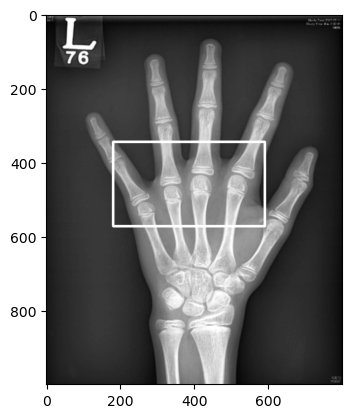

In [36]:
#손목뼈 위쪽에 있는 관절 4개를 추출
#오목하게 들어가 있는 부분중에서 가장 최저 x값(xrange[0])과 far_miny 값을 y값으로
#끝점으로는 가장 오목하게 들어가 있는 부분들 중에서 가장 최고 x값(xrange[-1])과 center의 y값을 준다.

four_start_point = ((int)(np.sort(far_xrange)[0]*0.85),int(far_miny*0.85))
four_end_point = (int(np.sort(far_xrange)[-1]*1.05),(int)(center[1]*1.1))

finger4=cv2.rectangle(np.copy(img0),four_start_point,four_end_point,[255,255,255],5)

#ROI 확인
print("가운데 4개 관절 roi 좌표")
plt.imshow(finger4,"gray")

### 중지 좌표 추출

중지 roi 좌표


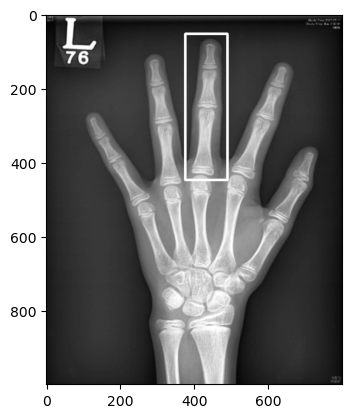

In [37]:
#중지 ROI 추출
#중지를 추출하기 위해서 start_pt의 x 좌표가 sorted_far_xrange 에서 3번째와 4번째 값 사이에 있어야 한다.
middle_index = np.where((start_pt[:,0]<=(int)(sorted_far_xrange[3])) & (start_pt[:,0]>=sorted_far_xrange[2]))[0]

#위에 조건식으로 나온 인덱스를 start_point에 대입하면 만족하는 좌표들이 여러개 나올것이다.
middle_points = start_pt[middle_index]


for point in middle_points:
    #가운데 손가락 사이에 있는 좌표들 중에서 최저 y 값을 찾는다.
    start_miny = min(start_miny,point[1])


start_maxy = max(far_yrange[np.where(far_xrange == sorted_far_xrange[3])[0][0]],far_yrange[np.where(far_xrange == sorted_far_xrange[2])[0][0]])
#시작 좌표로는 x값으로 sorted_far_xrange 에서 3번째와 y 값으로는 최저y 값을 주고 
#마지막 좌표로는 x값으로 sorted_far_xrange 에서 4번째와 y값으로는 3번째 와 4번째 좌표의 최고 y 값을 준다.
middle_finger_start_point = (sorted_far_xrange[2],int(start_miny*0.7))
middle_finger_end_point = (int(sorted_far_xrange[3]*1.03),int(start_maxy*1.1))

finger3=cv2.rectangle(np.copy(img0),middle_finger_start_point,middle_finger_end_point,[255,255,255],5)

#ROI 확인
print("중지 roi 좌표")
plt.imshow(finger3,"gray")

### 새끼손가락 좌표 추출

새끼손가락 roi 좌표


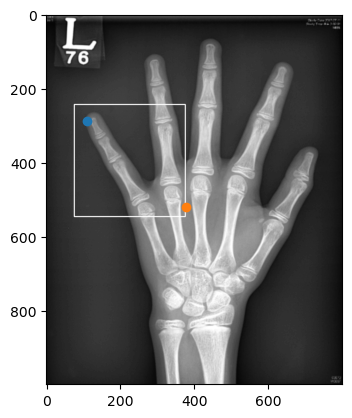

In [38]:
#새끼손가락 좌표
#새끼손가락 시작점 x좌표
little_finger_x = ()
little_finger_y = ()

min_little_finger_x = hull1[0][0][0]
for i in range(1, len(hull1)):
    if min_little_finger_x > hull1[i][0][0]:
        min_little_finger_x = hull1[i][0][0]
        little_finger_x, little_finger_y = hull1[i][0]


# 새끼손가락 endpoint x 좌표
little_finger_endpoint_x =[]
for x, y in zip(far_xrange, far_yrange):
    if y < int(center[1]*0.9) :
        little_finger_endpoint_x.append(x)

little_finger_start_point = (int(little_finger_x*0.7), int(little_finger_y * 0.85))
little_finger_end_point = (min(little_finger_endpoint_x),(int)(center[1]*1.05))

finger5=cv2.rectangle(np.copy(img0),little_finger_start_point, little_finger_end_point,[255,255,255],2)

#ROI 확인
print("새끼손가락 roi 좌표")
plt.imshow(finger5,"gray")
plt.scatter(little_finger_x, little_finger_y)
plt.scatter(min(little_finger_endpoint_x), center[1])

### 엄지손가락 좌표 추출

엄지손가락 roi 좌표


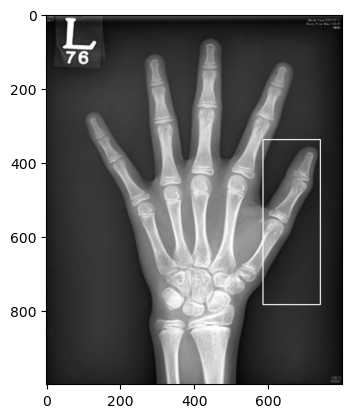

In [39]:
#엄지손가락 좌표

#엄지손가락 시작점 좌표
thumb_x = ()
thumb_y = ()

max_thumb_x = hull1[0][0][0]
for i in range(1,len(hull1)):
    if max_thumb_x < hull1[i][0][0]:
        max_thumb_x = hull1[i][0][0]            
        thumb_x, thumb_y = hull1[i][0] 
        
# 엄지손가락 endpoint
thumb_endpoint_list =[]
for x, y in zip(far_xrange, far_yrange):
    if y > int(center[1]):
        thumb_endpoint_list.append([x,y])

thumb_endpoint =[]
max_x = thumb_endpoint_list[0][0]
if len(thumb_endpoint_list) == 1:
    thumb_endpoint = thumb_endpoint_list
for i in range(1, len(thumb_endpoint_list)):       
    if max_x < thumb_endpoint_list[i][0]:
        max_x = thumb_endpoint_list[i][0]
        thumb_endpoint.append(thumb_endpoint_list[i])
    else:
        thumb_endpoint.append(thumb_endpoint_list[0])


#엄지손가락 ROI
thumb_start_point = (int(thumb_endpoint[0][0]*1.1), int(thumb_y*0.9))
thumb_end_point = (int(thumb_x * 1.02), int(thumb_endpoint[0][1]))

finger1=cv2.rectangle(np.copy(img0),thumb_start_point, thumb_end_point,[255,255,255],2)

#ROI 확인
print("엄지손가락 roi 좌표")
plt.imshow(finger1,"gray")

### Cropping


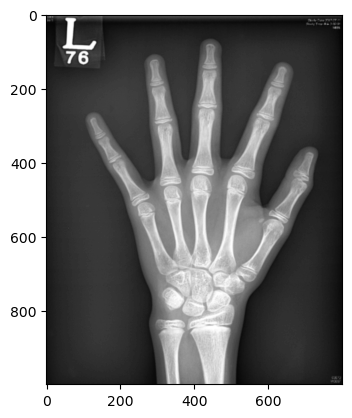

In [40]:
plt.imshow(img0, 'gray')

In [41]:
def optimize_img1(r1,r2,r3):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for _,img in enumerate([r1,r2,r3]):
        if img is not None:
            resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(resized_img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            # _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            tmp_binary_img.append(clahed_img)
                
    return np.array(tmp_binary_img)

In [42]:
def crop_img1(img, roi_1, roi_2, roi_3):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]].T
    
    optimzed_imgs = optimize_img1(cropped_roi_1_img,cropped_roi_2_img,cropped_roi_3_img)
    return optimzed_imgs

In [43]:
optimized_imgs = crop_img1(img0,(carpus_start_point,carpus_end_point),
                         (four_start_point, four_end_point),(middle_finger_start_point,middle_finger_end_point))

optimized_imgs.shape

(3, 400, 1000)

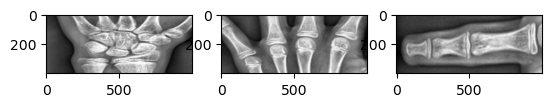

In [44]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(optimized_imgs[i], 'gray')

In [199]:
def optimize_img(r1,r2,r3):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for _,img in enumerate([r1,r2,r3]):
        if img is not None:
            resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(resized_img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            tmp_binary_img.append(binary_img)
                
    return np.array(tmp_binary_img)

In [206]:
def crop_img(img, roi_1, roi_2, roi_3):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]].T
    
    optimzed_imgs = optimize_img(cropped_roi_1_img,cropped_roi_2_img,cropped_roi_3_img)
    return optimzed_imgs

In [207]:
optimized_imgs = crop_img(img0,(carpus_start_point,carpus_end_point),
                         (four_start_point, four_end_point),(middle_finger_start_point,middle_finger_end_point))

optimized_imgs.shape

(3, 400, 1000)

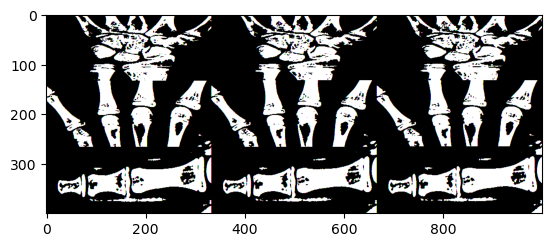

In [208]:
plt.imshow((optimized_imgs.reshape(400, 1000, -1)), 'gray')

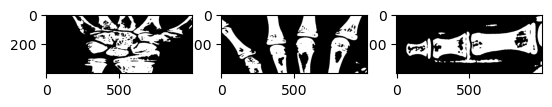

In [209]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(optimized_imgs[i], 'gray')